In [ ]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/IA/Proyecto')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/IA/Proyecto


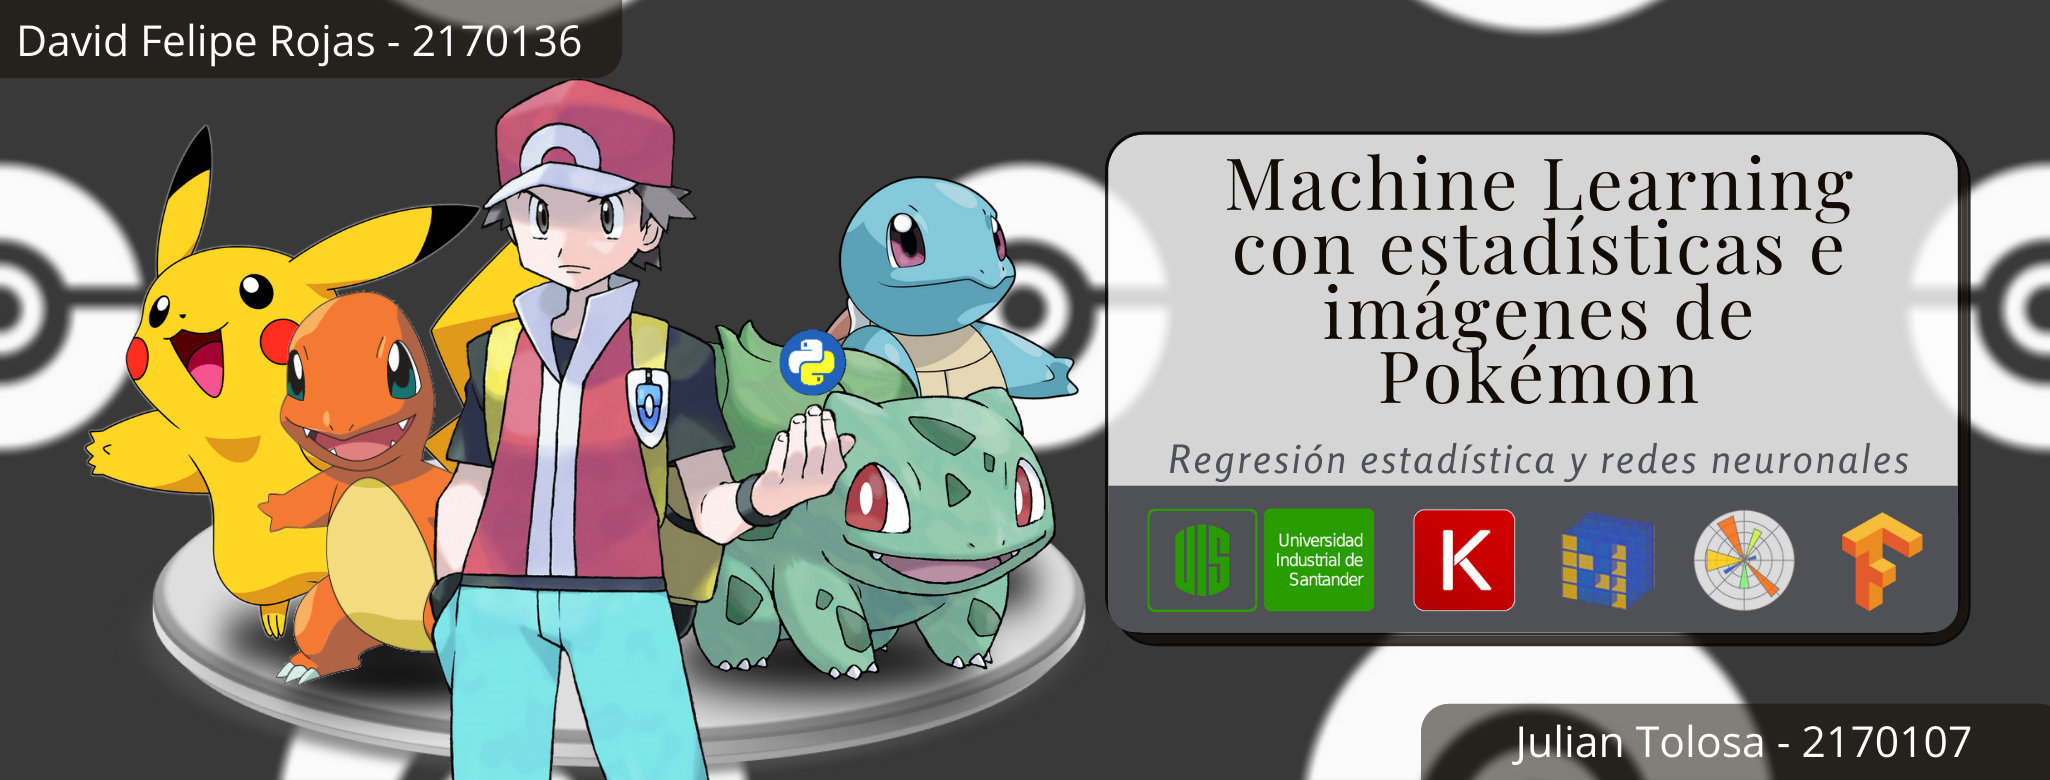

In [ ]:
#@title Importar librerías { display-mode: "form" }

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

### Definimos los datasets pokemon y combate

In [ ]:
pokemon = pd.read_csv("pokemon.csv")
#renombramos la columna "#" por "Number" ya que la necesitaremos luego
pokemon = pokemon.rename(index=str, columns={"#": "Number"})
combate = pd.read_csv("combats.csv")
pokemon.head()

Number           Name Type 1  Type 2  ...  Sp. Def  Speed  Generation  Legendary
0       1      Bulbasaur  Grass  Poison  ...       65     45           1      False
1       2        Ivysaur  Grass  Poison  ...       80     60           1      False
2       3       Venusaur  Grass  Poison  ...      100     80           1      False
3       4  Mega Venusaur  Grass  Poison  ...      120     80           1      False
4       5     Charmander   Fire     NaN  ...       50     65           1      False

[5 rows x 12 columns]

In [ ]:
combate.head()

First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

In [ ]:
print("Dimensiones del dataset Pokemon: " + str(pokemon.shape))
print("Dimenstions del dataset Combate: " + str(combate.shape))

Dimensiones del dataset Pokemon: (800, 12)
Dimenstions del dataset Combate: (50000, 3)


Miremos cuáles son los tipos de Pokémon más frecuentes a continuación.

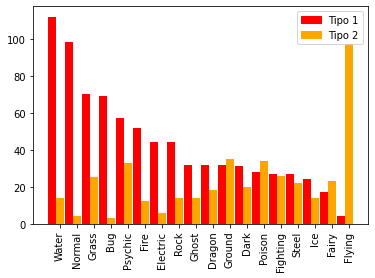

In [ ]:
valores1 = [pokemon['Type 1'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
valores2 = [pokemon['Type 2'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
inds = np.arange(len(pokemon['Type 1'].value_counts().index))
width = .45
handles = [patches.Patch(color='red', label='Tipo 1'), patches.Patch(color='orange', label='Tipo 2')]
plt.bar(inds, valores1, width, color='red')
plt.bar(inds+width, valores2, width, color='orange')
plt.gca().set_xticklabels(pokemon['Type 1'].value_counts().index)
plt.gca().set_xticks(inds+width)
plt.xticks(rotation=90)
plt.legend(handles=handles)

El agua es el tipo más común en el ataque primario, mientras que el volador es el tipo más común en el ataque secundario.

### Pokémon por generación

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64


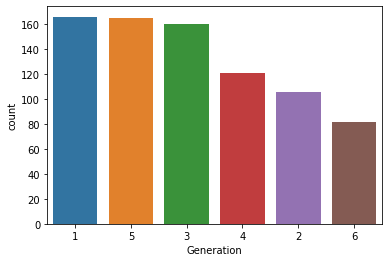

In [ ]:
print(pokemon['Generation'].value_counts())

sns.countplot(x='Generation', data=pokemon, order=pokemon['Generation'].value_counts().index)
plt.show()

Miremos si cada vez los pokémon tienen mejores estadísticas entre cada generación:

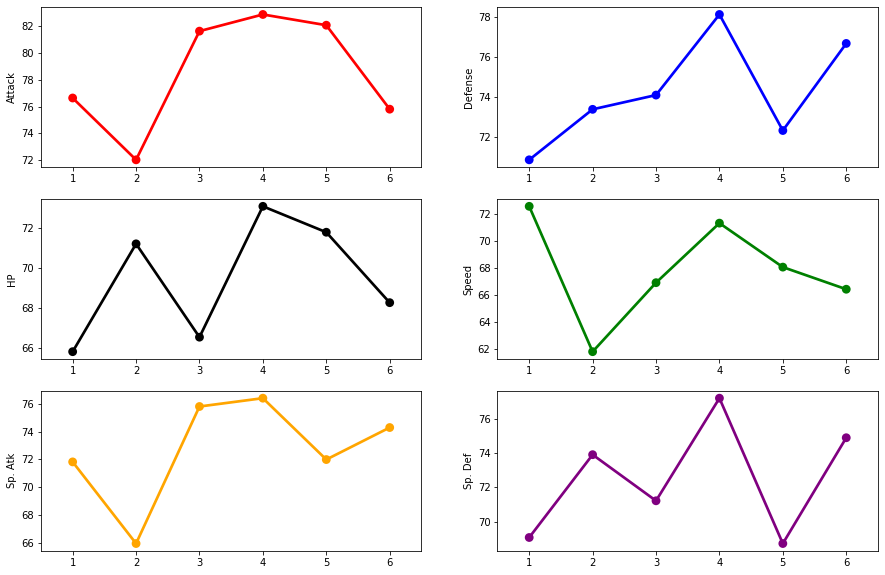

In [ ]:
group_df = pokemon.drop(['Number', 'Legendary'], axis=1)
pokemon_groups = group_df.groupby('Generation')
pokemon_groups_mean = pokemon_groups.mean()
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Attack'], color='red', ax=axes[0][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Defense'], color='blue', ax=axes[0][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['HP'], color='black', ax=axes[1][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Speed'], color='green', ax=axes[1][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Atk'], color='orange', ax=axes[2][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Def'], color='purple', ax=axes[2][1])

plt.show()

### Datos que faltan en el dataset  

In [ ]:
pokemon.isnull().sum()

Number          0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [ ]:
combate.isnull().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

Como podemos observar, hay 386 Pokémon que no tienen asignado un valor en la columna "Type 2". Esto es debido a que algunos pokémon no tienen un tipo secundario.
También hay un Pokémon el cual sale sin nombre en el dataset y procederemos a ver cuál es.

In [ ]:
print(pokemon[pokemon['Name'].isnull()])

    Number Name    Type 1 Type 2  ...  Sp. Def  Speed  Generation  Legendary
62      63  NaN  Fighting    NaN  ...       70     95           1      False

[1 rows x 12 columns]


Asumiendo que el dataset siga el mismo enumerado de la Pokedex tradicional, podemos saber cuál pokémon es el que falta con número 63. En este caso sería Primeape.

In [ ]:
pokemon['Name'][62] = "Primeape"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Comparación entre los tipos de pokémon

Realizaremos unos boxplots para cada estadística para ver cómo se diferencian los distintos tipos de pokémon.

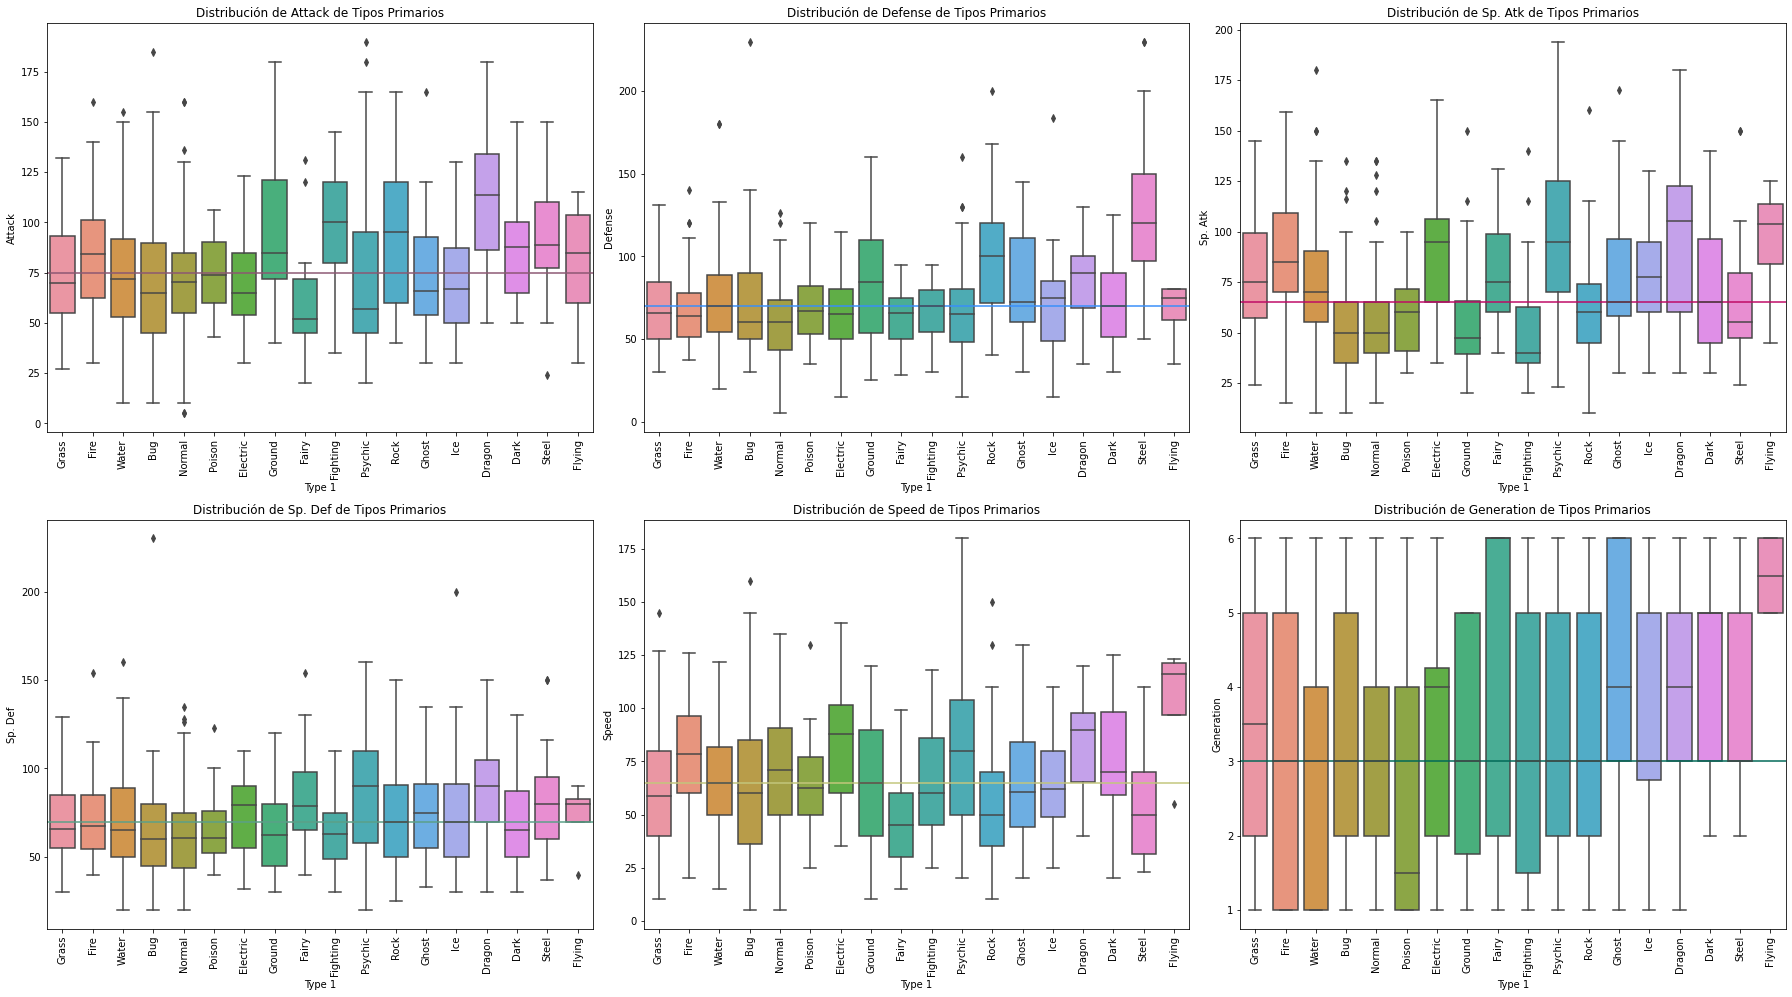

In [ ]:
stats = pokemon.columns[5:11]
plt.figure(figsize=(25,20))

for ii, stat in enumerate(stats):
    titulo = "Distribución de {stat} de Tipos Primarios".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(titulo)
    plt.xticks(rotation=90)
    sns.boxplot(x='Type 1', y=stat, data = pokemon)
    plt.axhline(pokemon[stat].median(), color=np.random.rand(3))
    
plt.tight_layout()
plt.show()

Principalmente notamos que los pokémon tipo dragón tienen ventaja en la mayoría de estadísticas. También, apreciamos que los pokémon tipo acero y tierra tienen ventajas sobre otros tipos en Defensa y Ataque. Los tipo volador tienen una ventaja significativa en la estadística de velocidad.

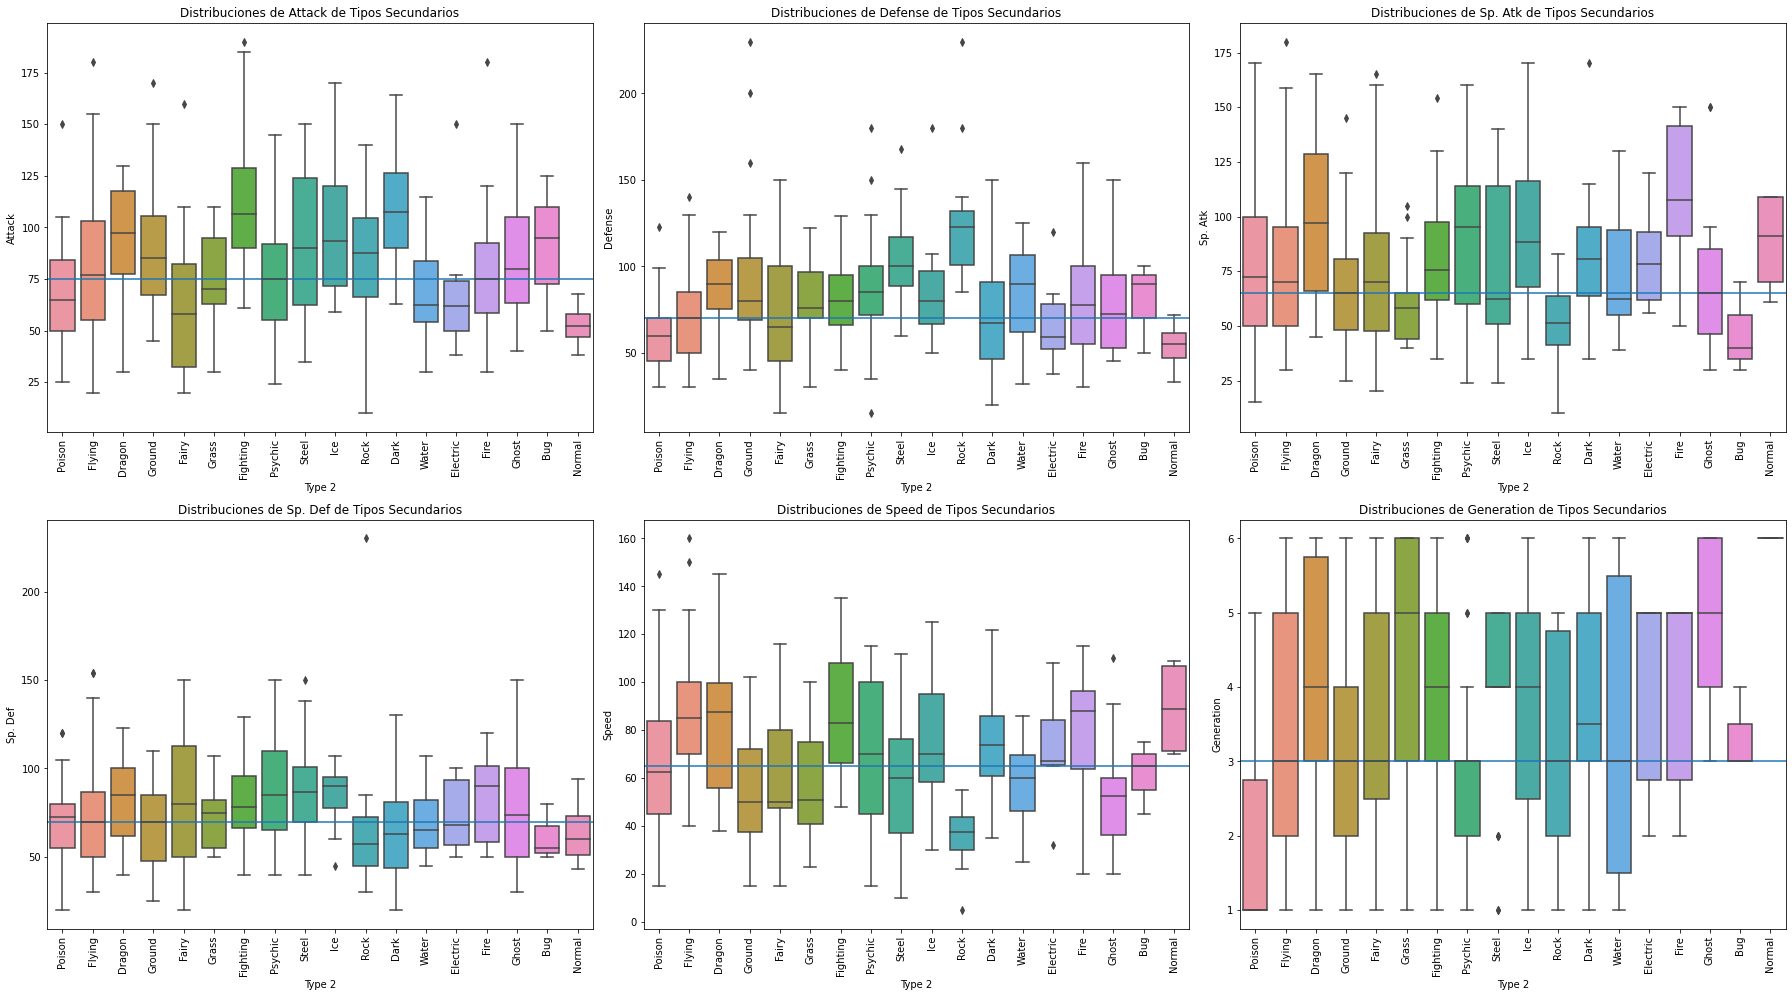

In [ ]:
plt.figure(figsize=(25,20))
for ii, stat in enumerate(stats):
    titulo = "Distribuciones de {stat} de Tipos Secundarios".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(titulo)
    plt.xticks(rotation=90)
    sns.boxplot(x='Type 2', y=stat, data = pokemon)
    plt.axhline(pokemon[stat].median())
    
plt.tight_layout()
plt.show()

### **Porcentaje de victorias para cada Pokémon**

Ahora con el dataset "combate" calcularemos el porcentaje de victorias para cada pokémon.

In [ ]:
# calcular el porcentaje de victorias para cada pokemon
totalvictorias = combate.Winner.value_counts()
# obtener el numero de victorias para cada pokemon
numerovictorias = combate.groupby('Winner').count()

contarprimero = combate.groupby('Second_pokemon').count()
contarsegundo = combate.groupby('First_pokemon').count()
print("Dimensiones de nuestros dataframes:")
print("Contador para primer ganador: " + str(contarprimero.shape))
print("Contador para segundo ganador: " + str(contarsegundo.shape))
print("Total de victorias: " + str(numerovictorias.shape))

Dimensiones de nuestros dataframes:
Contador para primer ganador: (784, 2)
Contador para segundo ganador: (784, 2)
Total de victorias: (783, 2)


Podemos ver que el shape en total de victorias es diferente al de los demás. Esto nos indica que hubo un pokémon el cual no pudo ganar en las batallas. Procederemos entonces a hallar cuál fue.

In [ ]:
buscar_pokemon_perdedor= np.setdiff1d(contarprimero.index.values, numerovictorias.index.values)-1 #offset because the index and number are off by one
pokemon_perdedor = pokemon.iloc[buscar_pokemon_perdedor[0],]
print(pokemon_perdedor)

Number            231
Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
Name: 230, dtype: object


En este caso el pokémon que no pudo ganar ninguna batalla fue Shuckle.

Ahora creamos una nueva columna llamada "Porcentaje de Victorias", combinando los datasets pokemon y combate.

In [ ]:
numerovictorias = numerovictorias.sort_index()
numerovictorias['batallastotales'] = contarprimero.Winner + contarsegundo.Winner
numerovictorias['porcenvictoria']= numerovictorias.First_pokemon/numerovictorias['batallastotales']

# unir los datasets
results2 = pd.merge(pokemon, numerovictorias, right_index = True, left_on='Number')
results3 = pd.merge(pokemon, numerovictorias, left_on='Number', right_index = True, how='left')

# miremos cuales pokemon no han tenido batallas
results3[results3['porcenvictoria'].isnull()]

Number                  Name  ... batallastotales porcenvictoria
11       12             Blastoise  ...             NaN            NaN
32       33             Sandshrew  ...             NaN            NaN
45       46            Wigglytuff  ...             NaN            NaN
65       66               Poliwag  ...             NaN            NaN
77       78            Victreebel  ...             NaN            NaN
89       90              Magneton  ...             NaN            NaN
143     144                 Ditto  ...             NaN            NaN
182     183               Ariados  ...             NaN            NaN
230     231               Shuckle  ...             NaN            NaN
235     236              Ursaring  ...             NaN            NaN
321     322              Hariyama  ...             NaN            NaN
418     419           Mega Latias  ...             NaN            NaN
478     479             Honchkrow  ...             NaN            NaN
555     556               Servine  ...             NaN            NaN
617     618              Maractus  ...             NaN            NaN
654     655             Jellicent  ...             NaN            NaN
781     782  Pumpkaboo Small Size  ...             NaN            NaN

[17 rows x 16 columns]

Como podemos ver, hay algunos pokémon que no participaron en ninguna batalla.

### Top 10 Pokemon con el peor porcentaje de victorias

In [ ]:
results3[np.isfinite(results3['porcenvictoria'])].sort_values(by = ['porcenvictoria']).head(10)

Number       Name  ... batallastotales porcenvictoria
289     290    Silcoon  ...           138.0       0.021739
189     190     Togepi  ...           122.0       0.024590
638     639    Solosis  ...           129.0       0.031008
236     237     Slugma  ...           123.0       0.032520
576     577      Munna  ...           128.0       0.039062
188     189  Igglybuff  ...           115.0       0.043478
394     395     Wynaut  ...           130.0       0.046154
209     210     Wooper  ...           125.0       0.048000
291     292    Cascoon  ...           133.0       0.052632
752     753   Spritzee  ...           133.0       0.060150

[10 rows x 16 columns]

### Top 10 Pokemon con el mejor porcentaje de victorias

In [ ]:
results3[np.isfinite(results3['porcenvictoria'])].sort_values(by = ['porcenvictoria'], ascending = False ).head(10)

Number                      Name  ... batallastotales porcenvictoria
154     155           Mega Aerodactyl  ...           129.0       0.984496
512     513                   Weavile  ...           119.0       0.974790
703     704    Tornadus Therian Forme  ...           125.0       0.968000
19       20             Mega Beedrill  ...           119.0       0.966387
153     154                Aerodactyl  ...           141.0       0.964539
476     477              Mega Lopunny  ...           129.0       0.961240
726     727                  Greninja  ...           127.0       0.960630
716     717  Meloetta Pirouette Forme  ...           123.0       0.959350
164     165             Mega Mewtwo Y  ...           125.0       0.952000
349     350             Mega Sharpedo  ...           120.0       0.950000

[10 rows x 16 columns]

Analizando estas dos tablas con el top 10 pokémon con mejores y peores porcentajes de victoria, podemos decir que las estadísticas del pokémon juegan un papel importante en quién va a ganar y perder. De igual forma, los pokémon con el prefijo "Mega" suelen ser los que más ganan.

### **Estadísticas básicas de los datos y visualización**

In [ ]:
results3.describe()

Number          HP  ...  batallastotales  porcenvictoria
count  800.0000  800.000000  ...       783.000000      783.000000
mean   400.5000   69.258750  ...       127.541507        0.501538
std    231.0844   25.534669  ...        11.397402        0.254993
min      1.0000    1.000000  ...        92.000000        0.021739
25%    200.7500   50.000000  ...       120.000000        0.284228
50%    400.5000   65.000000  ...       128.000000        0.491071
75%    600.2500   80.000000  ...       135.000000        0.717644
max    800.0000  255.000000  ...       164.000000        0.984496

[8 rows x 12 columns]

Text(0.5, 1.0, 'Total de Pokémon por Tipo 1')

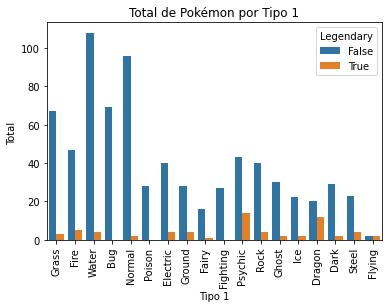

In [ ]:
sns.set_color_codes("pastel")
ax = sns.countplot(x="Type 1", hue="Legendary", data=results3)
plt.xticks(rotation= 90)
plt.xlabel('Tipo 1')
plt.ylabel('Total ')
plt.title("Total de Pokémon por Tipo 1")

Text(0.5, 1.0, 'Total de Pokémon por Tipo 2')

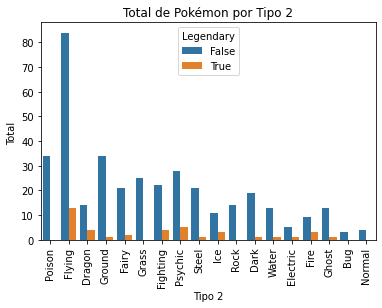

In [ ]:
ax = sns.countplot(x="Type 2", hue="Legendary", data=results3)
plt.xticks(rotation= 90)
plt.xlabel('Tipo 2')
plt.ylabel('Total ')
plt.title("Total de Pokémon por Tipo 2")

### Tabla de correlación

In [ ]:
col = ['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'porcenvictoria']
results3.loc[:,col].corr()

HP    Attack  ...     Speed  porcenvictoria
HP              1.000000  0.422386  ...  0.175952        0.258006
Attack          0.422386  1.000000  ...  0.381240        0.500181
Defense         0.239622  0.438687  ...  0.015227        0.129426
Sp. Atk         0.362380  0.396362  ...  0.473018        0.478940
Sp. Def         0.378718  0.263990  ...  0.259133        0.324218
Speed           0.175952  0.381240  ...  1.000000        0.937742
porcenvictoria  0.258006  0.500181  ...  0.937742        1.000000

[7 rows x 7 columns]

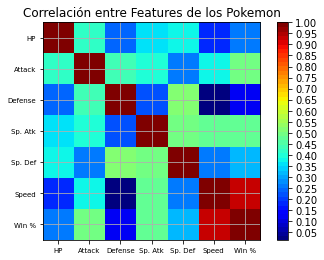

In [ ]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 50)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlación entre Features de los Pokemon')
    labels=['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win %']
    ax1.set_xticklabels(labels,fontsize=7)
    ax1.set_yticklabels(labels,fontsize=7)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.00,.05,.10,.15,.20,.25,.30,.35,.40,.45,.50,.55,.60,.65,.70,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(results3.loc[:,col])

Las features con mayor correlación a porcentaje de victorias son "Velocidad" y "Ataque"


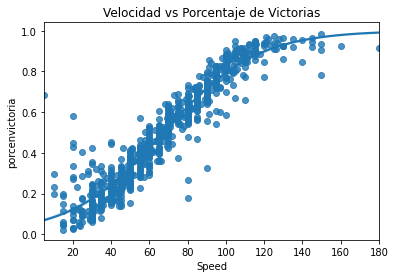

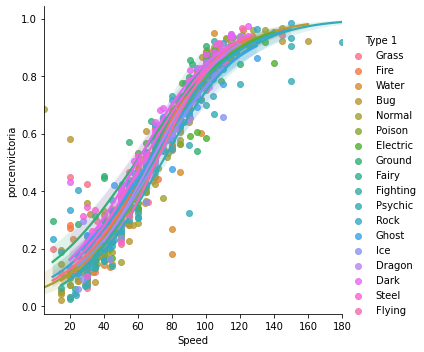

In [ ]:
sns.regplot(x="Speed", y="porcenvictoria", data=results3, logistic=True).set_title("Velocidad vs Porcentaje de Victorias")
sns.lmplot(x="Speed", y="porcenvictoria", data=results3, hue = 'Type 1',  logistic=True)

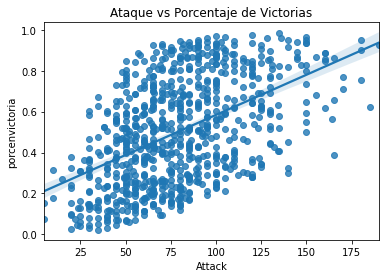

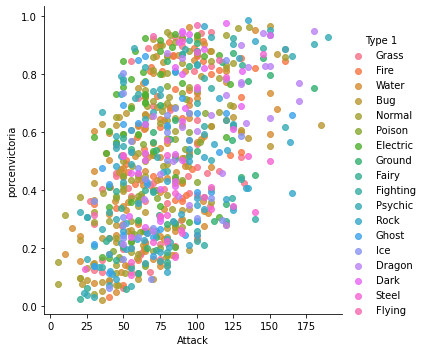

In [ ]:
ax = sns.regplot(x="Attack", y="porcenvictoria", data=results3).set_title("Ataque vs Porcentaje de Victorias")
sns.lmplot(x="Attack", y="porcenvictoria", data=results3, hue = 'Type 1',fit_reg =False)

### **Machine Learning**

Seleccionamos el dataset con el que trabajaremos:

In [ ]:
dataset=results2

Dividimos los datos para entrenamiento y testeo. En este caso escogimos el típico 80%-20%. Usaremos las columnas 5 a la 11 para los datos X y la columna 15 (porcentaje de victorias) para el label (y).

In [ ]:
dataset.dropna(axis=0, how='any') # quitamos las filas con valores NA porque podrían causar errores
X = dataset.values[:,5:11]
y = dataset.values[:,15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### **Modelos de regresión**

#### SVM

In [ ]:
def ml_svm(X_train, X_test, y_train, y_test):
    from sklearn.svm import SVR
    regressor = SVR(kernel = 'linear')
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))

    y_pred= regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_svm(X_train, X_test, y_train, y_test)

0.9065078337237095


0.06360099438357145

#### Decision Tree Regression

In [ ]:
def ml_decisiontree(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeRegressor
    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))


    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_decisiontree(X_train, X_test, y_train, y_test)

0.9997364298486605


0.05381006518627112

#### Random Forest Regressor

In [ ]:
def ml_randomforest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))

    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_randomforest(X_train, X_test, y_train, y_test)

0.9900335696113418


0.04998334826451492

In [ ]:
all_stats = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

0.9065078337237095
0.9997364298486605
0.9900335696113418


### **Principle Component Analysis (PCA)**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Aplicamos PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# Nos da un vector de la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("Esta es la varianza explicada por los componentes principales")
print(explained_variance)

This is the variance explained by the principle components
[0.41314124 0.17695566 0.16108936]


Una vez que miramos cuanta varianza provoca cada variable independiente, debemos decidir cuantos componentes queremos para el modelos. Entre más componentes mayor será la varianza en el modelo. 

Ahora volveremos a correr los algoritmos de SVM, Decision Tree y Random Forest luego de PCA:

In [ ]:
PCA = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

0.7526006202791979
0.99973644025325
0.9602173159076051


Reducimos las features a tan solo velocidad y ataque:

In [ ]:
dataset = results2
dataset.dropna(axis=0, how='any')
# Dividimos el dataset en training y test
X = dataset.loc[:, ['Attack','Speed']].values
y = dataset.loc[:, ['porcenvictoria']].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

reduced_stats = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9040040161126808
0.9930604360712907
0.9859902601183322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


### **Validación**

Luego de aplicar todos los modelos, comparemos los resultados:

In [ ]:
ml_results = pd.DataFrame({'Todos las estadísticas': all_stats, 'Estadísticas reducidas': reduced_stats, 'PCA': PCA})
ml_results.rename(index = {0:'SVM', 1:'Decision Tree', 2:'Random Forest'})

Todos las estadísticas  Estadísticas reducidas       PCA
SVM                          0.063601                0.064739  0.099990
Decision Tree                0.053810                0.054214  0.127740
Random Forest                0.049983                0.049369  0.096757

La tabla de arriba nos brinda una comparación en cuanto al error medio absoluto para cada modelo. El modelo con menor error fue el Random Forest con factores reducidos.